In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [2]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [3]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.9
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 5400
Test set size: 600


In [4]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]

In [5]:
dim1_data = t_x_data
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()

In [6]:
def sliding_window_delta(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length] - data[i+seq_length-1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

my_arr = np.array([1,2,3,7,8,9,1,2,3])
x,y = sliding_window_delta(my_arr,3)
print(x)
print(y)

[[1 2 3]
 [2 3 7]
 [3 7 8]
 [7 8 9]
 [8 9 1]
 [9 1 2]]
[ 4  1  1 -8  1  1]


In [7]:
def sliding_windows(data, seq_length, output_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-(1+output_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+output_length)]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

training_data = dim1_data_scaled.reshape(-1,1)

seq_length = 10
single_output_length = 1
# x, y = sliding_windows(training_data, seq_length, single_output_length)
x, y = sliding_window_delta(training_data, seq_length)

train_test_ratio = 0.85
train_size = int(len(y) * train_test_ratio)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX:",dataX.shape)
print("trainX:",trainX.shape)
print("testX:",testX.shape)
print("dataY:",dataY.shape)
print("trainY:",trainY.shape)
print("testY:",testY.shape)

dataX: torch.Size([5390, 10, 1])
trainX: torch.Size([4581, 10, 1])
testX: torch.Size([809, 10, 1])
dataY: torch.Size([5390, 1])
trainY: torch.Size([4581, 1])
testY: torch.Size([809, 1])


In [8]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_dim, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [9]:
torch.manual_seed(0)

num_epochs = 451
learning_rate = 0.01

input_size = 1
hidden_size = 30
num_layers = 1

lstm = LSTM(input_size, single_output_length, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

print(lstm(trainX).size())
print(trainY.size())

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX).reshape(-1,single_output_length)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([4581, 1])
torch.Size([4581, 1])
Epoch: 0, loss: 0.00796
Epoch: 50, loss: 0.00758
Epoch: 100, loss: 0.00695
Epoch: 150, loss: 0.00648
Epoch: 200, loss: 0.00508
Epoch: 250, loss: 0.00501
Epoch: 300, loss: 0.00499
Epoch: 350, loss: 0.00496
Epoch: 400, loss: 0.00494
Epoch: 450, loss: 0.00493


In [10]:
def appender(input_seq,new_val):
    """
    Append value to input sequence (treat as arrays)
    """
    input_seq = np.delete(input_seq,0)
    updated_input_seq = np.append(input_seq,new_val)
    return updated_input_seq
my_arr = np.array([0,2,4,6])
print(my_arr)
my_new_arr = appender(my_arr,8)
print(my_new_arr)

[0 2 4 6]
[2 4 6 8]


data size and type: torch.Size([5390, 10, 1]) <class 'torch.Tensor'>


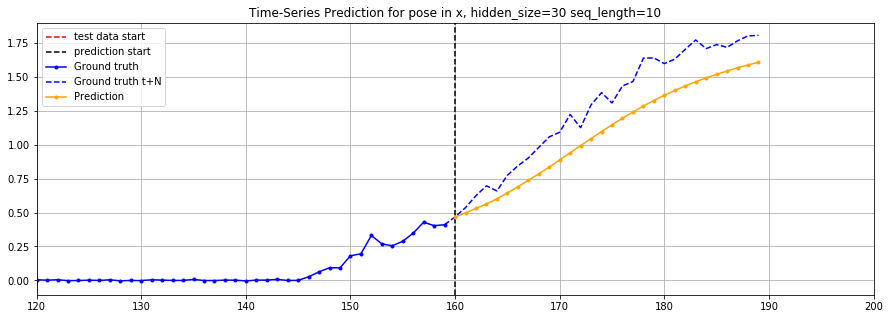

In [12]:
print("data size and type:",dataX.size(),type(dataX))

prediction_start_index = 160 #int(len(dataY)*train_test_ratio) + 10 #160
horizon = 30

lstm.eval()

input_seq = dataX[prediction_start_index]
future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()

output_collection = np.empty(0)
output_collection = np.append(output_collection,future_val)

for i in range(horizon-1):
    updated_input_seq = appender(input_seq,future_val)
    updated_input_seq = updated_input_seq[np.newaxis,...,np.newaxis]
    updated_input_seq = Variable(torch.tensor(updated_input_seq))
    next_prediction = lstm(updated_input_seq)
    
    # Update states
    input_seq = updated_input_seq
    future_val = next_prediction.data.numpy()+updated_input_seq[0][-1].data.numpy()
    output_collection = np.append(output_collection,future_val)
    
predictions = output_collection

# Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy())*dim1_data.std()+dim1_data.mean()

x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

plt.figure(figsize=(15,5))
plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
view_size = horizon+10
x_centre = prediction_start_index #len(dataY)*train_test_ratio
plt.xlim(x_centre-view_size,x_centre+view_size)
plt.plot(gt_vals_rescaled[:prediction_start_index,0],'b.-',label="Ground truth")
plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon,0],'b--',label="Ground truth t+N")
plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
             +' seq_length='+str(seq_length)
plt.title(title_string)
plt.grid()
plt.legend()

In [15]:
import datetime
from time import strftime
print(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

save_plots = True
prediction_start_index = 3500 #int(len(dataY)*train_test_ratio) - 50#140 #140
prediction_horizon = 100 -1 # -1 because we do first step outside the loop
num_frames_to_render = 300
experiment_dir = '/workspace/data/pose-prediction-odometry/'+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
if save_plots:
    os.mkdir(experiment_dir)
    for frame in range(prediction_start_index,prediction_start_index+num_frames_to_render):
        prediction_start_index = frame
        lstm.eval()
        input_seq = dataX[prediction_start_index]
        future_val = lstm(dataX[[prediction_start_index]]).data.numpy()[0][0] + dataX[prediction_start_index][-1].data.numpy()

        output_collection = np.empty(0)
        output_collection = np.append(output_collection,future_val)

        for i in range(horizon-1):
            updated_input_seq = appender(input_seq,future_val)
            updated_input_seq = updated_input_seq[np.newaxis,...,np.newaxis]
            updated_input_seq = Variable(torch.tensor(updated_input_seq))
            next_prediction = lstm(updated_input_seq)

            # Update states
            input_seq = updated_input_seq
            future_val = next_prediction.data.numpy()+updated_input_seq[0][-1].data.numpy()
            output_collection = np.append(output_collection,future_val)

        predictions = output_collection

        # Scale outputs up again after the inputs had been scaled down - using training data ONLY (dim1_data)
        data_predict_rescaled = predictions*dim1_data.std()+dim1_data.mean()
        gt_vals_rescaled = (dataX.data.numpy()[:,-1]+dataY.data.numpy())*dim1_data.std()+dim1_data.mean()

        x_axis_ticks_horizon = np.linspace(prediction_start_index,prediction_start_index+horizon-1,horizon)
        x_axis_ticks_tm1 = np.linspace(prediction_start_index-1,prediction_start_index+horizon-1,horizon+1)

        fig = plt.figure(figsize=(15,5))
        plt.axvline(x=train_size, c='r', linestyle='--',label="test data start")
        plt.axvline(x=prediction_start_index, c='k', linestyle='--',label="prediction start")
        view_size = horizon+10
        x_centre = prediction_start_index #len(dataY)*train_test_ratio
        plt.xlim(x_centre-view_size,x_centre+view_size)
        plt.plot(gt_vals_rescaled[:prediction_start_index,0],'b.-',label="Ground truth")
        plt.plot(x_axis_ticks_tm1,gt_vals_rescaled[prediction_start_index-1:prediction_start_index+horizon,0],'b--',label="Ground truth t+N")
        plt.plot(x_axis_ticks_horizon,data_predict_rescaled,'.-',color="orange",label="Prediction")

        title_string = 'Time-Series Prediction for pose in x, '+'hidden_size='+str(hidden_size) \
                     +' seq_length='+str(seq_length)
        plt.title(title_string)
        plt.grid()
        plt.legend()
        plt.savefig("%s%s%i%s%i%s" % (experiment_dir,'/hiddensize-',hidden_size,'-frame-',frame,'.png'), \
                bbox_inches='tight')
        plt.close(fig)

05-06-2020-11-52-51
